In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import einops
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class ToyModel(nn.Module):
    def __init__(self, num_classes, dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.t_embs = SinusoidalPosEmb(dim)
        layers = [nn.Linear(num_classes+1, 512), nn.LayerNorm(512), nn.GELU()]
        for _ in range(3):
            layers.extend([nn.Linear(512, 512),nn.LayerNorm(512), nn.GELU()])
        layers.append(nn.Linear(512, num_classes))
        self.net = nn.Sequential(*layers)
        self.softmax = nn.Softmax(-1)
    def forward(self, t, x, return_probs=False):
        """
        x: tensor of shape (batch_size, D, num_classes)
        """
        B, D, _ = x.shape
        # t_embs = self.t_embs(t)
        # t_embs = einops.repeat(t_embs, "B dim -> B D dim", D=D)
        t = einops.repeat(t.reshape(-1,1), "B C -> B D C ", D=D)
        x = torch.cat([x, t], dim=-1)
        out = self.net(x)
        if return_probs: return self.softmax(out)
        return out

In [4]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint


class CatFlow(nn.Module):
    def __init__(self, model, p0, obs_dim=(2,), sigma_min=1e-10, n_samples=10):
        super().__init__()
        self.model = model
        self.sigma_min = sigma_min
        self.obs_dim = obs_dim
        self.n_samples = n_samples
        self.cross_entropy = nn.CrossEntropyLoss(reduction='sum')
        self.eps_ = 1e-10
        self.softmax = nn.Softmax(-1)
        self.p0 = p0
    
    def process_timesteps(self, t, x):
        if len(t.shape) == 0:
            t = t.repeat(x.shape[0])
        if t.shape[0]!=x.shape[0] or len(t.shape)!=1:
            raise ValueError("Timesteps shape should (batch_size, )")
        return t

    def forward(self, t, x0, x1):
        """ 
        Computes velocity v from the equation dphi(t, x) = v(t, phi(t, x))dt. 
        """
        t = self.process_timesteps(t, x0)
        x = self.conditional_flow(t, x0, x1)
        return self.model(t, x)

    def velocity(self, t, x):
        t = self.process_timesteps(t, x)
        dims = [1]*(len(x.shape)-1)
        return (self.model(t, x, return_probs=True) - x)/(1-t.view(-1, *dims) + self.eps_)
    
    def reversed_velocity_with_div(self, t, state):
        s = 1-t
        x, logp = state
        x_ = x.detach().clone().requires_grad_(True)
        div_estimates = []
        with torch.set_grad_enabled(True):
            for i in range(self.n_samples):
                v = self.velocity(s, x_)
                is_last = (i == self.n_samples - 1)
                div_estimates.append(
                    self.approx_div(v, x_, retain_graph=not is_last)
                )
        
        mean_div = torch.stack(div_estimates).mean(dim=0)
        return ((-v).detach(), mean_div)

    def conditional_flow(self, t, x, x1):
        """
        Computes \phi(t,x) = \sigma(t, x1)x + \mu(t, x1), where \phi(0,x) = x = x0
        
        :param t: timestep. Float in [0,1].
        :param x0: starting point sampled from N(0, I).
        :param x1: observation
        """
        dims = [1]*(len(x.shape)-1)
        t = t.view(-1, *dims)
        values = t.expand(-1, x1.shape[1], 1)
        x_scaled = x * (1 - (1 - self.sigma_min) * t)
        return x_scaled.scatter_add(2, x1.unsqueeze(-1), values.to(x.dtype))
    
    def conditional_velocity(self, t, x, x1, eps=1e-7):
        """
        Computes (x1-x)/(1-t) =  - (x-x1)/(1-t) = - (x/(1-t) - x1/(1-t))
        """
        dims = [1]*(len(x.shape)-1)
        t = t.view(-1, *dims)
        denom = 1-t.expand(-1, x1.shape[1], 1) + eps
        values = - 1.0/denom
        x_scaled = x/denom
        return -x_scaled.scatter_add(2, x1.unsqueeze(-1), values.to(x.dtype))
    
    # def target_velocity(self, t, x, x1):
    #     return self.conditional_velocity(t, self.conditional_flow(t, x, x1), x1)
    
    # def criterion(self, t, x0, x1):
    #    v = self.forward(t, x0, x1)
    #    target = self.target_velocity(t, x0, x1)
    #    dim = tuple(torch.arange(1, len(x0.shape)))
    #    return torch.mean((v - target).pow(2).sum(dim=dim))

    def criterion(self, t, x0, x1):
        output = self.forward(t, x0, x1)
        return self.cross_entropy(output.transpose(1, 2), x1)/x0.shape[0]

    
    def sample(self, n_samples, method='midpoint', rtol=1e-5, atol=1e-5):
        self.device = next(self.parameters()).device
        x0 = self.p0.sample([n_samples]+list(self.obs_dim)).to(self.device)
        t = torch.linspace(0,1-self.eps_,100, device=self.device)
        with torch.no_grad():
            return odeint(self.velocity, x0, t, rtol=rtol, atol=atol, method=method, adjoint_params = self.model.parameters())[-1,:,:]
        

    def approx_div(self, f_x, x, retain_graph=True):
        z = torch.randint(low=0, high=2, size=x.shape).to(x) * 2 - 1
        e_dzdx = torch.autograd.grad(f_x, x, z, create_graph=True, retain_graph=retain_graph)[0]
        return (e_dzdx*z).view(z.shape[0], -1).sum(dim=1)

        
    def logp(self, x1, n_samples=50, rtol=1e-05, atol=1e-05):
        self.device = next(self.parameters()).device
        self.n_samples = n_samples
        t = torch.linspace(0, 1, 100, device=self.device )
        phi, f = odeint(
            self.reversed_velocity_with_div, 
            (x1, torch.zeros((x1.shape[0], 1))), 
            t, 
            rtol=rtol,
            atol=atol,
            adjoint_params = self.model.parameters(),
            )
        phi, f = phi[-1].detach().cpu(), f[-1].detach().cpu().flatten()
        logp_noise = self.p0.log_prob(phi) # should be changed to uniform dirichlet
        return logp_noise - f
    
    def __str__(self):
        """
        Model prints with the number of parameters.
        """
        all_parameters = sum([p.numel() for p in self.model.parameters()])
        trainable_parameters = sum(
            [p.numel() for p in self.model.parameters() if p.requires_grad]
        )

        result_info = super().__str__()
        result_info = result_info + f"\nAll parameters: {all_parameters}"
        result_info = result_info + f"\nTrainable parameters: {trainable_parameters}"

        return result_info

In [39]:
train_size = 512_000//8
D = 2
batch_size = 1024
num_classes = 5
p0 = torch.distributions.MultivariateNormal(torch.zeros(num_classes), torch.eye(num_classes))
p1 = torch.distributions.Dirichlet(torch.ones(num_classes))

In [40]:
target_distribution = p1.sample((D,))

In [41]:
target_distribution

tensor([[0.0773, 0.0559, 0.7557, 0.0241, 0.0870],
        [0.0692, 0.2042, 0.1617, 0.4118, 0.1531]])

In [42]:
cat = torch.distributions.Categorical(target_distribution)

In [43]:
train_data = cat.sample((train_size,))

In [44]:
kl = 0
for i in range(D):
    kl+=F.kl_div(
    torch.log(torch.mean((train_data[:, i, None] == torch.arange(num_classes)).float(), dim=0)),
    target_distribution[i],
    reduction='sum'
    ).item()

print("KL: ", kl)

KL:  9.342283010482788e-05


In [45]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

KL divergence:  6.999820470809937e-05


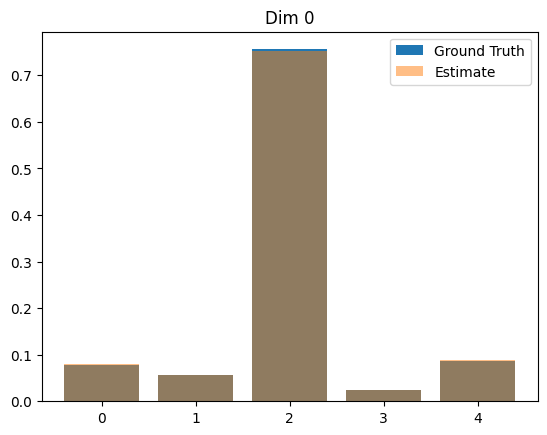

In [46]:
import matplotlib.pyplot as plt
import numpy as np
i = 0
ohe = torch.mean((train_data[:, i][:, None]==torch.arange(num_classes))*1.0, dim=0)
print("KL divergence: ", float(F.kl_div(torch.log(ohe), target_distribution[i], reduction='sum')))
plt.bar(np.arange(num_classes), target_distribution[i], label='Ground Truth')
plt.bar(np.arange(num_classes), ohe, alpha=0.5, label='Estimate')
plt.title(f"Dim {i}")
plt.legend();

In [47]:
model = ToyModel(num_classes)
catflow = CatFlow(model, obs_dim=(D, ), p0=p0)

In [48]:
optimizer = torch.optim.AdamW(catflow.parameters(), lr=1e-4)

In [49]:
total_loss = []
from tqdm import tqdm
pbar = tqdm(range(100), desc='Training: ')
for epoch in pbar:
    epoch_loss = 0.0
    for x1 in train_loader:
        batch_size, D = x1.shape
        x0 = catflow.p0.sample((batch_size, D))
        t = torch.rand((batch_size,))
        loss = catflow.criterion(t, x0, x1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    total_loss.append(epoch_loss/len(train_loader))
    pbar.set_postfix({'Loss':total_loss[-1]})

Training: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, Loss=1.67]


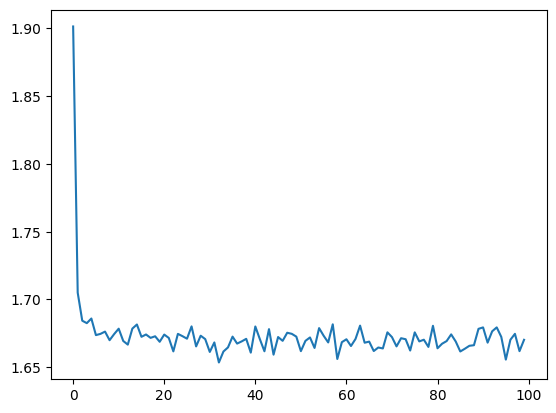

In [50]:
import matplotlib.pyplot as plt
plt.plot(total_loss)

In [51]:
samples = []
for x1 in tqdm(train_loader):
    sample = catflow.sample(x1.shape[0])
    samples.append(sample)
    # break

100%|██████████| 63/63 [00:45<00:00,  1.38it/s]


In [52]:
samples = torch.cat(samples, dim=0)

In [58]:
samples

tensor([[[1.9173e-05, 1.0061e-05, 9.9994e-01, 1.3672e-05, 1.4899e-05],
         [1.9219e-05, 1.0035e-05, 9.9994e-01, 1.3614e-05, 1.4858e-05]],

        [[1.9331e-05, 9.9991e-06, 9.9994e-01, 1.3577e-05, 1.4999e-05],
         [1.9108e-05, 1.0107e-05, 9.9994e-01, 1.3539e-05, 1.5013e-05]],

        [[1.9193e-05, 1.0132e-05, 9.9994e-01, 1.3631e-05, 1.4985e-05],
         [1.9284e-05, 1.0023e-05, 9.9994e-01, 1.3587e-05, 1.4995e-05]],

        ...,

        [[9.9990e-01, 1.4249e-05, 3.7994e-05, 2.4726e-05, 2.1437e-05],
         [3.0774e-05, 2.6301e-05, 2.6674e-05, 9.9990e-01, 1.5678e-05]],

        [[1.9162e-05, 1.0019e-05, 9.9994e-01, 1.3542e-05, 1.5100e-05],
         [3.0247e-05, 2.6086e-05, 2.6371e-05, 9.9990e-01, 1.5763e-05]],

        [[9.9990e-01, 1.4240e-05, 3.7729e-05, 2.4674e-05, 2.1553e-05],
         [4.2110e-05, 3.9865e-05, 5.9051e-05, 2.9324e-05, 9.9983e-01]]])

In [59]:
empirical = torch.mean((samples[:, 0].argmax(-1).flatten()[:, None]== torch.arange(num_classes)).float(), dim=0)

In [60]:
empirical

tensor([0.0798, 0.0953, 0.4972, 0.2171, 0.1107])

In [61]:
target_distribution[0]

tensor([0.0773, 0.0559, 0.7557, 0.0241, 0.0870])

In [62]:
F.kl_div(torch.log(empirical), target_distribution[0], reduction='mean')

/var/folders/xd/1tsv1g313s98001gbgdj7q0c0000gn/T/ipykernel_4135/2574264066.py:1: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  F.kl_div(torch.log(empirical), target_distribution[0], reduction='mean')


tensor(0.0420)

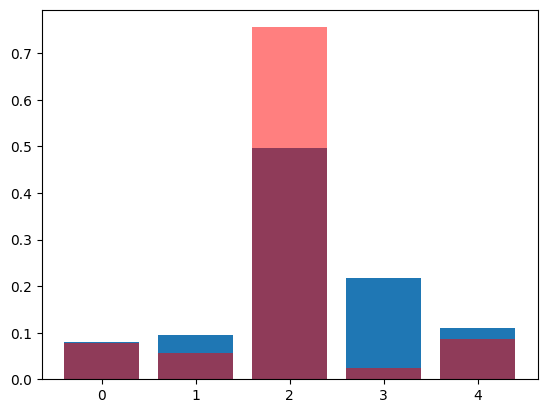

In [65]:
for d in range(D):
    plt.bar(torch.arange(num_classes), empirical)
    plt.bar(torch.arange(num_classes), target_distribution[0], alpha=0.5, color='r')
    break